In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
%matplotlib inline

In [2]:
shelterDf = pd.read_csv('Austin_Animal_Center_Outcomes.csv')

# Data Exploration

In [3]:
shelterDf.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A682730,Freddy,03/19/2019 06:54:00 PM,03/19/2019 06:54:00 PM,07/04/2013,Return to Owner,NaN,Dog,Neutered Male,5 years,Pit Bull Mix,Fawn
1,A790982,Blue,03/19/2019 06:54:00 PM,03/19/2019 06:54:00 PM,12/19/2017,Return to Owner,NaN,Dog,Intact Male,1 year,Pit Bull Mix,Blue/White
2,A790653,*O'Brian,03/19/2019 06:35:00 PM,03/19/2019 06:35:00 PM,09/13/2017,Adoption,NaN,Dog,Spayed Female,1 year,Pembroke Welsh Corgi Mix,Red/White
3,A475011,Tobie,03/19/2019 06:14:00 PM,03/19/2019 06:14:00 PM,05/11/2006,Return to Owner,NaN,Dog,Intact Male,12 years,German Shepherd Mix,Black/White
4,A790581,Mia,03/19/2019 06:11:00 PM,03/19/2019 06:11:00 PM,03/12/2018,Adoption,NaN,Dog,Spayed Female,1 year,Pit Bull Mix,Black/White


In [4]:
shelterDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97101 entries, 0 to 97100
Data columns (total 12 columns):
Animal ID           97101 non-null object
Name                67197 non-null object
DateTime            97101 non-null object
MonthYear           97101 non-null object
Date of Birth       97101 non-null object
Outcome Type        97093 non-null object
Outcome Subtype     43953 non-null object
Animal Type         97101 non-null object
Sex upon Outcome    97099 non-null object
Age upon Outcome    97093 non-null object
Breed               97101 non-null object
Color               97101 non-null object
dtypes: object(12)
memory usage: 8.9+ MB


In [5]:
shelterDf.nunique()

Animal ID           87157
Name                16563
DateTime            80244
MonthYear           80244
Date of Birth        6371
Outcome Type            9
Outcome Subtype        20
Animal Type             5
Sex upon Outcome        5
Age upon Outcome       49
Breed                2372
Color                 567
dtype: int64

In [6]:
shelterDf['Animal Type'].value_counts()

Dog          55508
Cat          35964
Other         5165
Bird           452
Livestock       12
Name: Animal Type, dtype: int64

We're going to focus on cats and dogs

# Data Cleaning

There is a lot of subjectivity in determining an animals breed and color e.g. many of the colors/breeds have only one animal assigned to that type. Therefore, we are only going to be looking at the top 10 breeds and drop the color feature

In [7]:
print('--Breeds--')
print(shelterDf['Breed'].value_counts().tail(10))
print('--Colors--')
print(shelterDf['Color'].value_counts().tail(10))

--Breeds--
Dachshund/Australian Kelpie              1
American Sable Mix                       1
Wire Hair Fox Terrier/German Shepherd    1
Anatol Shepherd/Kangal                   1
Catahoula/Chow Chow                      1
Border Collie/Miniature Pinscher         1
Jack Russell Terrier/Boston Terrier      1
Rex-Mini/Lop-English                     1
Rat Terrier/Miniature Pinscher           1
Border Collie/Brittany                   1
Name: Breed, dtype: int64
--Colors--
Black/Seal Point             1
Yellow Brindle/Blue          1
Brown Merle/Gray             1
Fawn/Chocolate               1
Blue Tabby/Orange            1
Orange Tabby/Black           1
Brown Brindle/Blue Cream     1
Blue/Black Brindle           1
Brown Brindle/Brown Merle    1
Yellow/Yellow                1
Name: Color, dtype: int64


In [8]:
shelterDf = shelterDf[shelterDf.groupby('Breed').Breed.transform(len) > 1000].copy()
print('Number of Breeds: ' + str(shelterDf['Breed'].nunique()))
print('Number of Animals: ' + str(shelterDf['Breed'].count()))

Number of Breeds: 10
Number of Animals: 58935


In [9]:
print(shelterDf[shelterDf['Animal Type'] == 'Other']['Breed'].value_counts())
print(shelterDf[shelterDf['Animal Type'] == 'Other']['Outcome Type'].value_counts())

Bat Mix    1680
Name: Breed, dtype: int64
Euthanasia    1464
Disposal       169
Died            44
Name: Outcome Type, dtype: int64


The animals in the 'other' category are all bats and I highly doubt bats are up for adoption. They will be dropped from the data set

In [10]:
shelterDf = shelterDf[shelterDf['Animal Type'] != 'Other']

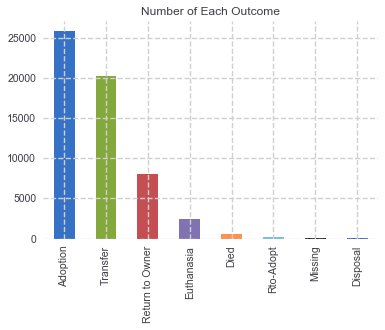

In [11]:
shelterDf['Outcome Type'].value_counts().plot(kind = 'bar', title = 'Number of Each Outcome')
plt.show()

Seems to be a pretty effective shelter although transfer doesn't mean adopted rather they were trasfered to another facility 

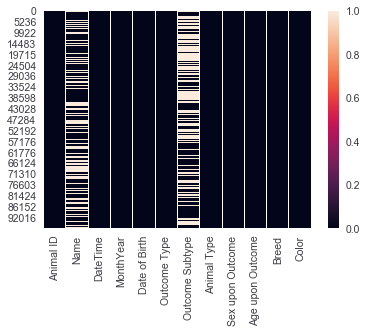

In [12]:
sns.heatmap(shelterDf.isnull())
plt.show()

In [13]:
shelterDf.isnull().sum()

Animal ID               0
Name                19061
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type            3
Outcome Subtype     28595
Animal Type             0
Sex upon Outcome        1
Age upon Outcome        4
Breed                   0
Color                   0
dtype: int64

Lets get rid of a few of those missing values 

In [14]:
shelterDf = shelterDf[shelterDf['Sex upon Outcome'].isnull() == False]
shelterDf = shelterDf[shelterDf['Outcome Type'].isnull() == False]

In [15]:
shelterDf.isnull().sum()

Animal ID               0
Name                19060
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type            0
Outcome Subtype     28592
Animal Type             0
Sex upon Outcome        0
Age upon Outcome        2
Breed                   0
Color                   0
dtype: int64

The missing 'Age upon Outcome' wont be a problem since I will be calculating it a different way below

Will be best to just drop Name and Outcome Subtype (will drop later)

In [16]:
# Add feature 'Was Adopted', 1 is adopted, 0 not adopted
shelterDf['Was Adopted'] = shelterDf['Outcome Type'].apply(lambda x: 1 if x == 'Adoption' else 0)

In [17]:
# If the 'name' column has a float then its NaN
shelterDf['Has Name'] = shelterDf['Name'].apply(lambda x: 1 if not isinstance(x, float) else 0)

In [18]:
# Make 'datetime' and 'date_of_birth' datetime objects
# There is several typos in Date of Birth so we'll drop those
shelterDf['DateTime'] = shelterDf['DateTime'].apply(lambda x: datetime.datetime.strptime(x[0:-3], '%m/%d/%Y %H:%M:%S'))
shelterDf['Date of Birth'] = shelterDf['Date of Birth'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))

In [19]:
# Make 'month' and 'year' features
shelterDf['Month'] = shelterDf['DateTime'].apply(lambda x: x.month)
shelterDf['Year'] = shelterDf['DateTime'].apply(lambda x: x.year)

In [20]:
# Change 'age upon outcome' to days for cosistency
shelterDf['Age upon Outcome'] = shelterDf['DateTime'] - shelterDf['Date of Birth']
daysRegex = re.compile('\d+')
shelterDf['Age upon Outcome'] = shelterDf['Age upon Outcome'].apply(lambda x: round(int(daysRegex.search(str(x)).group())))

In [21]:
# Data starts in 2013 and is incomplete
shelterDf['Year'].value_counts()

2015    11034
2016    10876
2017    10726
2014    10425
2018     9912
2013     2554
2019     1725
Name: Year, dtype: int64

They started data collection in 2013 and its only March 2019 currently, so its expected to have much less animals in those years

In [22]:
# To use 'year' as a predictor we can only use complete years
shelterDf = shelterDf[shelterDf['Year'] != 2013]
shelterDf = shelterDf[shelterDf['Year'] != 2019]

In [23]:
shelterDf['Sex upon Outcome'].value_counts()

Neutered Male    17913
Spayed Female    17096
Intact Female     7586
Intact Male       7369
Unknown           3009
Name: Sex upon Outcome, dtype: int64

In [24]:
# Dropping unknown sex upon outcome since they dont give us much information
shelterDf = shelterDf[shelterDf['Sex upon Outcome'] != 'Unknown']

In [25]:
# Seperate 'Sex upon outcome' into 'is male' and 'is fixed'
# 'is fixed' = 0 implies the animal is not spayed or neutered
sexRegex = re.compile('(\w*)\s*(Male|Female|Unknown)')
sexRegex.search('Unknown').groups()

shelterDf['is male'] = shelterDf['Sex upon Outcome'].apply(lambda x: int(sexRegex.search(str(x)).group(2) == 'Male'))
shelterDf['is fixed'] = shelterDf['Sex upon Outcome'].apply(lambda x: int(sexRegex.search(str(x)).group(1) in ['Spayed', 'Neutered']))


*Drop any columns that are no longer needed*

In [26]:
# Drop Name and Outcome Subtype: too many NaN
# Drop MonthYear: redundant
# Drop Color
# Drop Animal ID
# Drop DateTime
# Drop Date of Birth
# Drop Sex upon Outcome
shelterDf.drop(['Date of Birth','DateTime', 'Name', 'Outcome Subtype', 'Outcome Type', 'MonthYear', 'Color', 'Animal ID', 'Sex upon Outcome'], axis = 1, inplace = True)
shelterDf.dropna(inplace = True)

In [27]:
shelterDf.isnull().sum()

Animal Type         0
Age upon Outcome    0
Breed               0
Was Adopted         0
Has Name            0
Month               0
Year                0
is male             0
is fixed            0
dtype: int64

In [28]:
shelterDf.reset_index(inplace=True, drop=True)
shelterDf.head(3)

,Animal Type,Age upon Outcome,Breed,Was Adopted,Has Name,Month,Year,is male,is fixed
0,Dog,228,German Shepherd Mix,1,1,12,2018,1,0
1,Cat,61,Domestic Shorthair Mix,1,0,12,2018,0,1
2,Cat,1096,Domestic Shorthair Mix,1,1,12,2018,0,1


In [29]:
shelterDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49964 entries, 0 to 49963
Data columns (total 9 columns):
Animal Type         49964 non-null object
Age upon Outcome    49964 non-null int64
Breed               49964 non-null object
Was Adopted         49964 non-null int64
Has Name            49964 non-null int64
Month               49964 non-null int64
Year                49964 non-null int64
is male             49964 non-null int64
is fixed            49964 non-null int64
dtypes: int64(7), object(2)
memory usage: 3.4+ MB


# Data Visualization

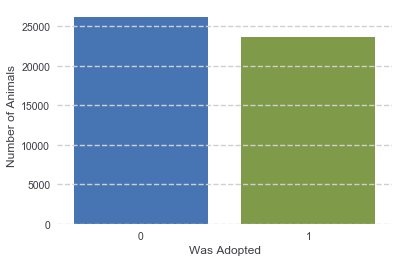

In [30]:
# Take a quick look at number of adoptions vs number of non-adoptions
sns.countplot(shelterDf['Was Adopted']).set_ylabel('Number of Animals')
plt.show()

About a 50-50 split showing that the data is fairly symmetric and predictions wont be too skewed toward adopted or not adopted

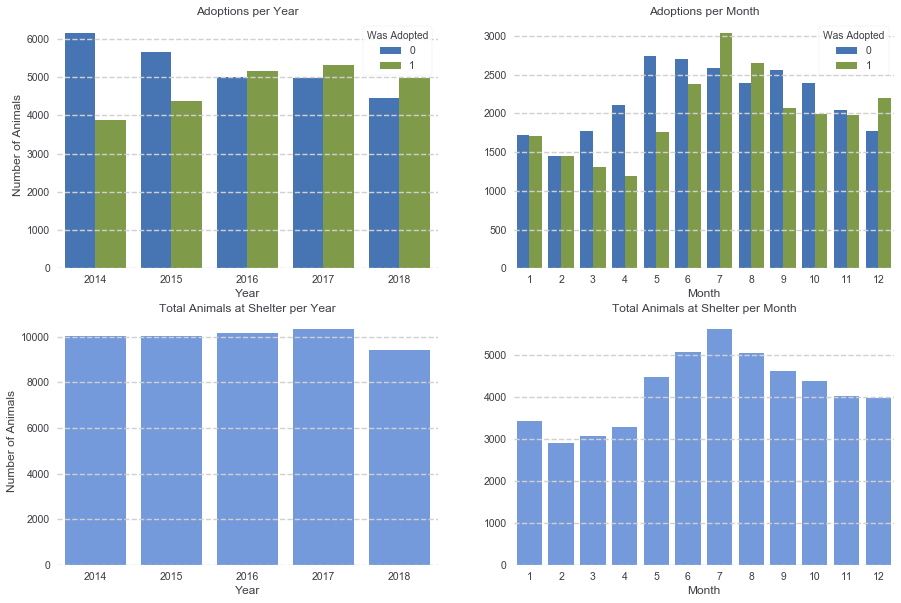

In [31]:
# Graphs of adoptions per year and per month
fig, axes = plt.subplots(figsize = (15,10), ncols =2, nrows = 2)
sns.countplot(shelterDf['Year'], hue = shelterDf['Was Adopted'], ax = axes[0,0]).set_title('Adoptions per Year')
sns.countplot(shelterDf['Month'],hue = shelterDf['Was Adopted'], ax = axes[0,1]).set_title('Adoptions per Month')
sns.countplot(shelterDf['Year'], ax = axes[1,0], color = 'cornflowerblue').set_title('Total Animals at Shelter per Year')
sns.countplot(shelterDf['Month'], ax = axes[1,1], color = 'cornflowerblue').set_title('Total Animals at Shelter per Month')

axes[0,0].set_ylabel('Number of Animals')
axes[1,0].set_ylabel('Number of Animals')
axes[0,1].set_ylabel('')
axes[1,1].set_ylabel('')
plt.show()

There appears to be a slight increase in adoptions from 2014 to 2018 while the total number of animals remains roughly the same. 

Adoptions in early months are significantly less than in later months but there are also less animals in the shelter in total. This makes sense since the increase in adoption at the end of the year will result in people not needing a pet and less animals in the shelter. The late year influx in adoptions is likely do to the holiday season and new pets being given as gifts

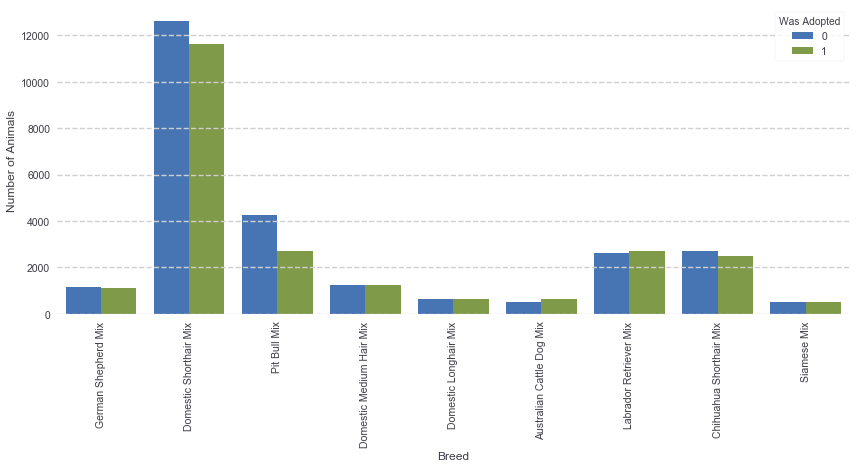

In [32]:
plt.figure(figsize= (12,5))
sns.countplot(x = 'Breed', data = shelterDf, hue = 'Was Adopted')
plt.tight_layout()
plt.xticks(rotation = 90)
plt.ylabel('Number of Animals')
plt.show()

It wouldn't seem that breed has much impact on whether an animal get adopted. 'Domestic Shorthair Mix' is the most common breed. I assume that is because its difficult to classify cats any further than 'Short hair', 'Long hair', etc.

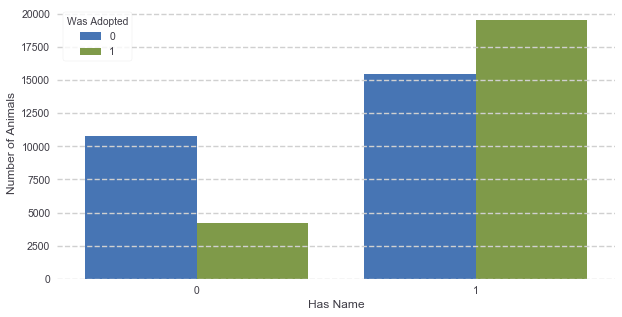

In [33]:
plt.figure(figsize= (10,5))
df = shelterDf.sample(frac = 0.01).reset_index(drop=True)

sns.countplot(shelterDf['Has Name'], hue = shelterDf['Was Adopted']).set_ylabel('Number of Animals')
plt.show()

It is clear that animals with names were much more likely to get adopted. This could be because a named animal is more likely to be well behaved and healthy, since it would likely have come from a home rather than the streets. However, there could also be cases were the shelter names found animals themselves. 

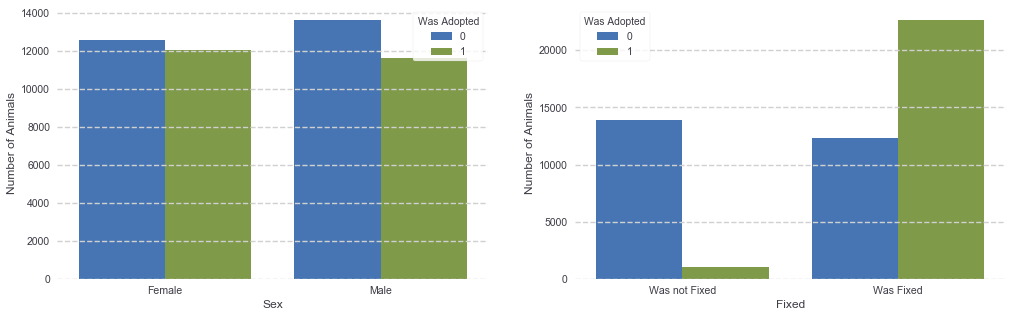

In [34]:
f,axes = plt.subplots(ncols = 2, figsize = (17,5))
sns.countplot(data = shelterDf, x = 'is male', hue = 'Was Adopted', ax = axes[0])
sns.countplot(data = shelterDf, x = 'is fixed', hue = 'Was Adopted', ax = axes[1])
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Number of Animals')
axes[0].set_xticklabels(['Female', 'Male'])
axes[1].set_xlabel('Fixed')
axes[1].set_ylabel('Number of Animals')
axes[1].set_xticklabels(['Was not Fixed', 'Was Fixed'])

plt.show()

The sex of the animal doesnt seem to matter much in terms of adoption. In the 'Fixed' graph you can clearly see that very few animals that were adopted were not fixed. However, it is unclear whether animals are fixed before some one adopts them or if after they adopt the animal the shelter spays/neuters them. I suspect its the latter case since the shelter may not want to waste resources fixing an animal that may not be adopted. Also shelters are encouraging spaying/neutering animals upon adoption to help deal with overpopulation.

Therefore, I believe its best to not use 'is fixed' as a predictor since it may be occuring after an adoption takes place

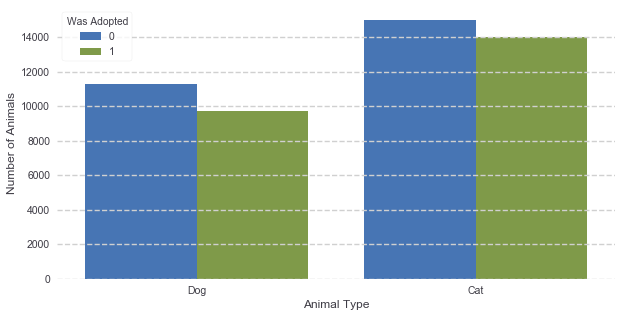

In [35]:
plt.figure(figsize = (10,5))
sns.countplot(data = shelterDf, x = 'Animal Type', hue = 'Was Adopted')
plt.ylabel('Number of Animals')
plt.show()

Adoption across based on Animal Type seems to be about the same with a little less than half of both cats and dogs being adopted.

C:\Users\TinyPoots\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


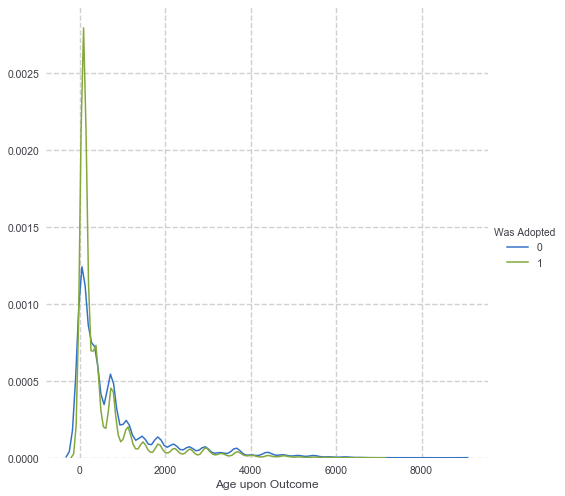

In [36]:
f = sns.FacetGrid(shelterDf, hue="Was Adopted", height=7)
f.map(sns.kdeplot, "Age upon Outcome") 
f.add_legend()
plt.show()

Clear that majority of adoptions and outcomes in general happen when the animals are young. There is a peak at about the 2 year mark (730 days). This could be due to the shelter having an age limit when an animals needs to be adopted, transfered, etc. This will likely be a strong predictor for the later models.

# Preproccessing

Based on the previous graphs there seem to be several insignificant features but the only that may cause data leakage is 'is fixed'

In [37]:
badFeatures = ['is fixed']

In [38]:
shelterDf.drop(badFeatures, axis =1, inplace = True )

Standardize and Encode

In [39]:
scaledDf = shelterDf.copy()

In [40]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [41]:
scaler = StandardScaler()
le = LabelEncoder()

In [42]:
scaledDf['Age upon Outcome'] = scaler.fit_transform(shelterDf['Age upon Outcome'].values.reshape(-1,1))

C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [43]:
scaledDf['Month'] = scaler.fit_transform(shelterDf['Month'].values.reshape(-1,1))

C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [44]:
scaledDf['Year'] = scaler.fit_transform(shelterDf['Year'].values.reshape(-1,1))

C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Not worried about warnings. Int -> float is fine

In [45]:
scaledDf['Breed'] = le.fit_transform(shelterDf['Breed'])

In [46]:
scaledDf['Animal Type'] = le.fit_transform(shelterDf['Animal Type'])

In [47]:
shelterDf.head(3)

,Animal Type,Age upon Outcome,Breed,Was Adopted,Has Name,Month,Year,is male
0,Dog,228,German Shepherd Mix,1,1,12,2018,1
1,Cat,61,Domestic Shorthair Mix,1,0,12,2018,0
2,Cat,1096,Domestic Shorthair Mix,1,1,12,2018,0


In [48]:
scaledDf.head(3)

,Animal Type,Age upon Outcome,Breed,Was Adopted,Has Name,Month,Year,is male
0,1,-0.477748,5,1,1,1.593411,1.440512,1
1,0,-0.637510,4,1,0,1.593411,1.440512,0
2,0,0.352631,4,1,1,1.593411,1.440512,0


Encoding Breed probably wont be very useful since there are 9 of them but we'll try anyways

# Prediction

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X = scaledDf.drop(['Was Adopted'], axis =1)
y = scaledDf['Was Adopted']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

**Model Selection**

In [52]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score

In [53]:
# Parameter grids
param_grid_log = [{'penalty': ['l1', 'l2'],'C': [1,2,3,4],'solver': ['liblinear']}]
param_grid_lsvc = [{'C':[1,2,3,4], 'max_iter': [1000,1500,2000]}]
param_grid_kn = [{'n_neighbors': [10,100,200,500] , 'weights': ['uniform', 'distance']}]

In [54]:
# Logistical Regression
log_grid = GridSearchCV(LogisticRegression(),param_grid_log,refit = True, n_jobs = 5, cv = 5, 
                        scoring='f1_macro')
log_grid.fit(X_train,y_train)
log_grid.best_score_

0.6585494465537768

In [55]:
# Linear SVC
lsvc_grid = GridSearchCV(LinearSVC(),param_grid_lsvc,refit = True, n_jobs = -1, cv = 5, 
                        scoring='f1_macro')
lsvc_grid.fit(X_train,y_train)
lsvc_grid.best_score_

C:\Users\TinyPoots\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6577531648044131

In [56]:
# KNeighbors
kn_grid = GridSearchCV(KNeighborsClassifier(),param_grid_kn,refit = True, n_jobs = -1, cv = 5, 
                        scoring='f1_macro')
kn_grid.fit(X_train,y_train)
kn_grid.best_score_

0.7140837058254418

In [57]:
kn_grid.best_params_

{'n_neighbors': 200, 'weights': 'distance'}

All the models had about the same f1-scores with KNeighbors edging the other to by about 0.05

We'll now test our KNeighbors model on our test data

In [58]:
kn = kn_grid.best_estimator_

In [59]:
predictions = kn.predict(X_test)

In [60]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.72      0.75      0.74      8590
           1       0.72      0.68      0.70      7899

   micro avg       0.72      0.72      0.72     16489
   macro avg       0.72      0.72      0.72     16489
weighted avg       0.72      0.72      0.72     16489

[[6470 2120]
 [2535 5364]]


fl-score of 0.72 is serviceable

Now I want to perform dimension reduction through PCA and then see how KNeighbors performs in lower dimensions

In [61]:
from sklearn.decomposition import PCA

In [62]:
scores = {}
for n in range(1,X.shape[1]+1):
    print(f"n = {n}")
    pca = PCA(n_components=n)
    X_new = pca.fit_transform(X_train,y_train)
    kn = KNeighborsClassifier(n_neighbors= 200, weights= 'distance')
    score = cross_val_score(kn,X_new,y_train,cv = 5,scoring = 'f1_macro') 
    scores[n] = score.mean()

n = 1
n = 2
n = 3
n = 4
n = 5
n = 6
n = 7


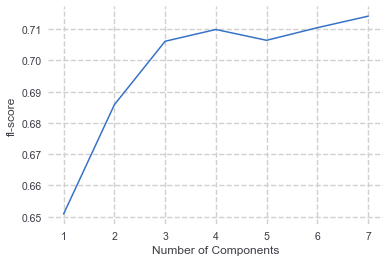

In [63]:
sns.lineplot(x = list(scores.keys()), y = list(scores.values()));
plt.xlabel('Number of Components')
plt.ylabel('fl-score');

A model using 3-components seems to be the ideal balance between simplicity and accuracy

**Conclusion**

The data was pretty ugly. 1000's of breeds and colors were not suitable for machine learning. To fix that problem one could try to group breeds and colors into similar groups. However, differentiating between 'Black/White' or 'White/Black' would be almost impossible. We 'cheated' in that sense by only looking at the more popular breeds. This did lead to being able make a fairly accurate model to predict adoption but it only applies to about half the animals at the shelter at a given time. 

If one was inclined to go further with this data to try and improve on our model I do have a couple ideas. Our model selection wasn't very rigourous and could definitely be improved by considering more models such as Random Forests. More hyperparameter tuning may also be able to squeeze a little more accuracy out this data.